Looing for differential expression between the three diseases conditions in the data (Normal/CKD/AKF) in terms of specifically complement genes

# Import Packages and Datasets

In [1]:
# Import packages
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [3]:
# Import dataset
## ~ 33k Genes
adata = sc.read_h5ad('/Users/aumchampaneri/Databases/Human_Nor-CKD-AKF_scRNA.h5ad')  # Disk Location
adata

AnnData object with n_obs × n_vars = 225177 × 31332
    obs: 'orig.ident', 'nCount_RNA', 'SpecimenID', 'LibraryID', 'SampleID', 'Run', 'clusterNumber', 'subclass.l1', 'dataSource', 'diseasetype', 'Race', 'clusterClass', 'organism_ontology_term_id', 'assay_ontology_term_id', 'sampletype', 'disease_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'Age_binned', 'cell_type_ontology_term_id', 'author_cell_type', 'diabetes_history', 'hypertension', 'eGFR', 'is_primary_data', 'disease_category', 'nFeature_RNA', 'percent.mt', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'index', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'default_embedding', 'sche

# Preprocess Data and Quality Control

In [4]:
# Preprocessing of the Data

# Basic filtering
# Filter out cells that express fewer than 500 genes to remove low-quality cells, empty droplets, and debris.
sc.pp.filter_cells(adata, min_genes=500, inplace=True)
# Filter out genes that are detected in fewer than 3 cells to eliminate technical noise and very rarely expressed genes.
sc.pp.filter_genes(adata, min_cells=3, inplace=True)

'''
Annotate the group of mitochondrial genes as 'mt'
Calculate QC metrics for further filtering

# normal.var["mt"] = normal.var_names.str.startswith("MT-")
# sc.pp.calculate_qc_metrics(normal, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

Violin plots of QC metrics -- give us information about how to proceed with filtering
Show NO mitochondrial genes and no cells with high total counts -- No further filtering
Uncomment to see the plots

# sc.pl.violin(normal, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(normal, x="total_counts", y="pct_counts_mt")
# sc.pl.scatter(normal, x="total_counts", y="n_genes_by_counts")
'''

# Normalize, log-transform, and scale the data
# Normalize the total gene expression in each cell to a target sum of 10,000 to correct for differences in sequencing depth.
sc.pp.normalize_total(adata, target_sum=1e4)
# Apply a natural logarithm transformation to the normalized data to stabilize variance and make expression values more comparable.
sc.pp.log1p(adata)

# Identify and plot highly-variable genes
# Identify highly-variable genes based on their mean expression and dispersion.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(scRNA_nor)

# Store the raw data before further processing
adata.raw = adata.copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Generate PCA and UMAP plus calculate Dendrogram Keys

In [5]:
'''
> Already calculated PCA and UMAP in the data adata.obsn(X_pca) and adata.obsm(X_umap) respectively

# Principal Component Analysis (PCA)
sc.pp.pca(adata, svd_solver="arpack")
# Plot the PCA -- Uncomment to see the plot
# sc.pl.pca(scRNA_nor)
# sc.pl.pca_variance_ratio(scRNA_nor, log=True)

# Generate UMAP
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Leiden clustering
sc.tl.leiden(adata, flavor='igraph', n_iterations=2)
sc.pl.umap(adata, color=['cell_type'])  # Looks better with dark background
'''

# Dendrogram Key for downstream visualization
sc.tl.dendrogram(adata, groupby='cell_type')

# Dictionary of Genes and Cell Types

## Gene Dictionaries

In [6]:
# All Complement Genes
gene_dict = {
    'C1D': 'ENSG00000197223',
    'C1QA': 'ENSG00000173372',
    'C1QB': 'ENSG00000173369',
    'C1QC': 'ENSG00000159189',
    'C1QBP': 'ENSG00000108561',
    'C1R': 'ENSG00000159403',
    'C1RL': 'ENSG00000139178',
    'C1S': 'ENSG00000182326',
    'C2_ENSG00000166278': 'ENSG00000166278',
    'C3_ENSG00000125730': 'ENSG00000125730',
    'C3AR1': 'ENSG00000171860',
    'C4A': 'ENSG00000244731',
    'C4B': 'ENSG00000224389',
    'C4BPA': 'ENSG00000123838',
    'C4BPB': 'ENSG00000123843',
    'C5': 'ENSG00000106804',
    'C5AR1': 'ENSG00000197405',
    'C5AR2': 'ENSG00000134830',
    'C6_ENSG00000039537': 'ENSG00000039537',
    'C7_ENSG00000112936': 'ENSG00000112936',
    'C8A': 'ENSG00000157131',
    'C8B': 'ENSG00000021852',
    'C8G': 'ENSG00000176919',
    'C9_ENSG00000113600': 'ENSG00000113600',
    'CALR': 'ENSG00000179218',
    'CD46': 'ENSG00000117335',
    'CD55': 'ENSG00000196352',
    'CD59': 'ENSG00000085063',
    'CD93': 'ENSG00000125810',
    'CFB': 'ENSG00000243649',
    'CFD': 'ENSG00000197766',
    'CFH': 'ENSG00000000971',
    'CFHR1': 'ENSG00000244414',
    'CFHR2': 'ENSG00000080910',
    'CFHR3': 'ENSG00000116785',
    'CFHR4': 'ENSG00000134365',
    'CFHR5': 'ENSG00000134389',
    'CFI': 'ENSG00000205403',
    'CLU': 'ENSG00000120885',
    'COLEC10': 'ENSG00000184374',
    'COLEC11': 'ENSG00000118004',
    'CPB2': 'ENSG00000080618',
    'CPN1': 'ENSG00000120054',
    'CPN2': 'ENSG00000178772',
    'CSMD1': 'ENSG00000183117',
    'CFP': 'ENSG00000126759',
    'CR1': 'ENSG00000203710',
    'CR2': 'ENSG00000117322',
    'FCN1': 'ENSG00000085265',
    'FCN2': 'ENSG00000160339',
    'FCN3': 'ENSG00000142748',
    'ITGAM': 'ENSG00000169896',
    'ITGAMX': 'XXX',
    'ITGAX': 'ENSG00000140678',
    'ITGB2': 'ENSG00000160255',
    'MASP1': 'ENSG00000127241',
    'MASP2': 'ENSG00000009724',
    'MASP3': 'XXX',
    'MBL2': 'ENSG00000165471',
    'SERPING1': 'ENSG00000149131',
    'SUSD4': 'ENSG00000143502',
    'VSIG4': 'ENSG00000155659',
    'VCP': 'ENSG00000165280'
}

# Extract keys and values into separate lists
gene_dict_names = list(gene_dict.keys())
gene_dict_keys = list(gene_dict.values())

print("gene_names =", gene_dict_names)
print("gene_keys =", gene_dict_keys)


# Create filter gene object
def filter_genes(gene_dict_names, genes_to_remove):
    # Filter out genes that are in the genes_to_remove list
    filtered_genes = [gene for gene in gene_dict_names if gene not in genes_to_remove]
    return filtered_genes

# Example list of genes to remove
genes_to_remove = ['C1QA', 'C1QB', 'C1QC', 'C1QBP']

# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict, genes_to_remove)
print(filtered_gene_list)

gene_names = ['C1D', 'C1QA', 'C1QB', 'C1QC', 'C1QBP', 'C1R', 'C1RL', 'C1S', 'C2_ENSG00000166278', 'C3_ENSG00000125730', 'C3AR1', 'C4A', 'C4B', 'C4BPA', 'C4BPB', 'C5', 'C5AR1', 'C5AR2', 'C6_ENSG00000039537', 'C7_ENSG00000112936', 'C8A', 'C8B', 'C8G', 'C9_ENSG00000113600', 'CALR', 'CD46', 'CD55', 'CD59', 'CD93', 'CFB', 'CFD', 'CFH', 'CFHR1', 'CFHR2', 'CFHR3', 'CFHR4', 'CFHR5', 'CFI', 'CLU', 'COLEC10', 'COLEC11', 'CPB2', 'CPN1', 'CPN2', 'CSMD1', 'CFP', 'CR1', 'CR2', 'FCN1', 'FCN2', 'FCN3', 'ITGAM', 'ITGAMX', 'ITGAX', 'ITGB2', 'MASP1', 'MASP2', 'MASP3', 'MBL2', 'SERPING1', 'SUSD4', 'VSIG4', 'VCP']
gene_keys = ['ENSG00000197223', 'ENSG00000173372', 'ENSG00000173369', 'ENSG00000159189', 'ENSG00000108561', 'ENSG00000159403', 'ENSG00000139178', 'ENSG00000182326', 'ENSG00000166278', 'ENSG00000125730', 'ENSG00000171860', 'ENSG00000244731', 'ENSG00000224389', 'ENSG00000123838', 'ENSG00000123843', 'ENSG00000106804', 'ENSG00000197405', 'ENSG00000134830', 'ENSG00000039537', 'ENSG00000112936', 'ENSG0

## Cell Type Dictionaries

In [8]:
# List all the cell types in the dataset
cell_types = adata.obs['cell_type'].unique()
print("Cell Types:")
for cell_type in cell_types:
    print(f"  {cell_type}")

# Define the groups for cell types
cell_type_groups = {
    'Myeloid Cells': ['monocyte', 'non-classical monocyte', 'mononuclear phagocyte',
                      'conventional dendritic cell', 'plasmacytoid dendritic cell, human'],
    'Kidney Cells': ['kidney distal convoluted tubule epithelial cell', 'epithelial cell of proximal tubule',
                     'kidney connecting tubule epithelial cell', 'kidney loop of Henle thick ascending limb epithelial cell',
                     'kidney collecting duct intercalated cell', 'kidney collecting duct principal cell',
                     'kidney loop of Henle thin descending limb epithelial cell', 'kidney loop of Henle thin ascending limb epithelial cell',
                     'kidney interstitial cell', 'podocyte', 'parietal epithelial cell', 'kidney interstitial alternatively activated macrophage'],
    'Endothelial Cells': ['endothelial cell'],
    'Epithelial Cells': ['podocyte', 'parietal epithelial cell'],
    'Immune Cells': ['T cell', 'cytotoxic T cell', 'natural killer cell', 'mature NK T cell',
                     'B cell', 'mast cell', 'plasma cell'],
}

# Map cell types to groups
adata.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_groups.items():
    adata.obs.loc[adata.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

# Check the new amount of cell types
cell_type_groups = adata.obs['cell_type_group'].unique()
print("Cell Type Groups:")
for group in cell_type_groups:
    print(f"  {group}")

Cell Types:
  kidney collecting duct principal cell
  kidney interstitial cell
  kidney loop of Henle thin descending limb epithelial cell
  endothelial cell
  epithelial cell of proximal tubule
  kidney loop of Henle thick ascending limb epithelial cell
  kidney loop of Henle thin ascending limb epithelial cell
  kidney collecting duct intercalated cell
  cytotoxic T cell
  non-classical monocyte
  conventional dendritic cell
  T cell
  kidney interstitial alternatively activated macrophage
  mature NK T cell
  plasma cell
  mononuclear phagocyte
  monocyte
  B cell
  natural killer cell
  plasmacytoid dendritic cell, human
  mast cell
  kidney distal convoluted tubule epithelial cell
  podocyte
  parietal epithelial cell
  kidney connecting tubule epithelial cell
Cell Type Groups:
  Kidney Cells
  Endothelial Cells
  Immune Cells
  Myeloid Cells
  Epithelial Cells


# Plotting the Data

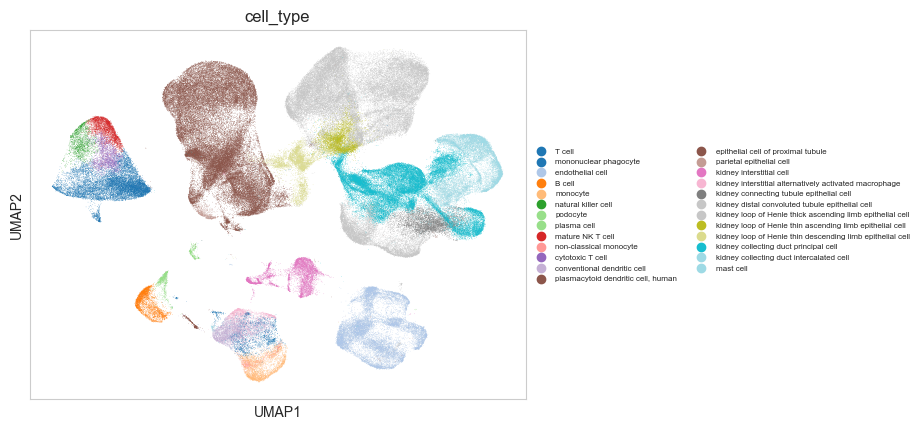

In [16]:
sc.pl.umap(adata,
           color=['cell_type'],
           legend_fontsize='xx-small',
           legend_fontweight='light',
           palette='tab20',
           # save='_cell-type_nor1.pdf'
           )

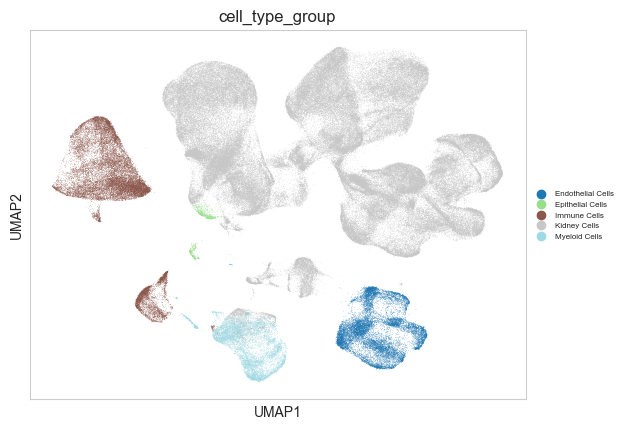

In [18]:
sc.pl.umap(adata,
           color=['cell_type_group'],
           legend_fontsize='xx-small',
           legend_fontweight='light',
           palette='tab20',
           # save='_cell-type-group_nor1.pdf'
           )

# Differential Expression Analysis

In [1]:
# Check if all the gene_dict_keys are in adata.var_names then remove any not present
gene_dict_keys = [gene for gene in gene_dict_keys if gene in adata.var_names]

# Adjust the gene_dict dictionary to only contain the genes that are present in gene_dict_keys
filtered_gene_dict = {gene: gene_dict[gene] for gene in gene_dict if gene_dict[gene] in gene_dict_keys}

print("Filtered gene names:", gene_dict_keys)
print("Filtered gene dictionary:", filtered_gene_dict)

sc.pl.MatrixPlot(adata, filtered_gene_dict,  groupby='disease_category', log=False, use_raw=True).show()
sc.pl.MatrixPlot(adata, filtered_gene_dict,  groupby='cell_type', log=False, use_raw=True).show()

NameError: name 'gene_dict_keys' is not defined

In [36]:
adata.var_names

Index(['ENSG00000243485', 'ENSG00000238009', 'ENSG00000241860',
       'ENSG00000286448', 'ENSG00000235146', 'ENSG00000237491',
       'ENSG00000177757', 'ENSG00000228794', 'ENSG00000225880',
       'ENSG00000230368',
       ...
       'ENSG00000276256', 'ENSG00000278384', 'ENSG00000273748',
       'ENSG00000271254', 'ENSG00000276345', 'ENSG00000277856',
       'ENSG00000275063', 'ENSG00000273554', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=29893)

In [58]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Perform differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='disease_category', method='wilcoxon')

# Extract the results
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pvals = pd.DataFrame({group: result['pvals'][group] for group in groups})
logfoldchanges = pd.DataFrame({group: result['logfoldchanges'][group] for group in groups})

# Prepare data for volcano plot
group = 'Normal'  # Change this to the group you are interested in
df = pd.DataFrame({
    'gene': result['names'][group],
    'logFC': logfoldchanges[group],
    'pval': pvals[group]
})
df['-log10(pval)'] = -np.log10(df['pval'])

# Filter the dataframe to include only genes in filtered_gene_dict
filtered_df = df[df['gene'].isin(filtered_gene_dict.keys())]

# Create volcano plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filtered_df['logFC'], filtered_df['-log10(pval)'], c=adata.obs['disease_category'].map({'Normal': 'blue', 'CKD': 'green', 'AKF': 'red'}), alpha=0.5)
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')
plt.title(f'Volcano Plot for {group}')
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')  # p-value threshold
plt.axvline(x=1, color='b', linestyle='--')  # logFC threshold
plt.axvline(x=-1, color='b', linestyle='--')  # logFC threshold
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'CKD', 'AKF'])
plt.show()

KeyboardInterrupt: 

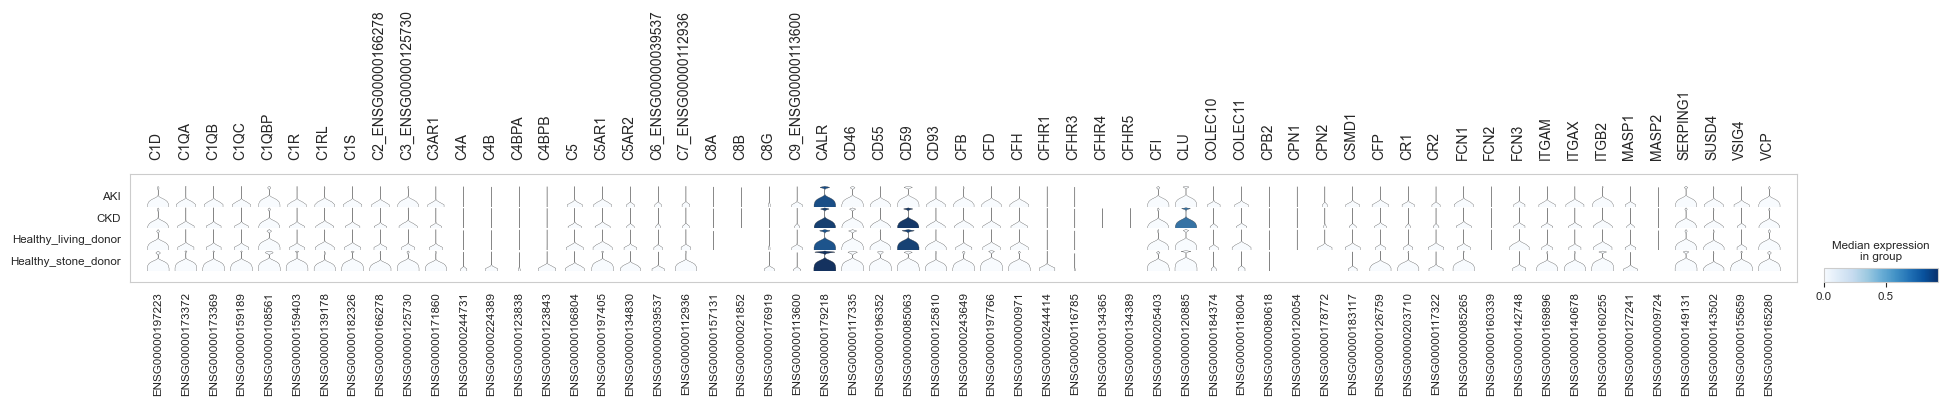

In [71]:
sc.pl.stacked_violin(adata, filtered_gene_dict, groupby='disease_category',log=True, use_raw=False)